In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 22,
    "image_size": 224,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s]


In [8]:
# ---------------- LOSS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7961 | F1: 0.4138
[Validate] Cardiomegaly AUC: 0.8534 | F1: 0.3300
[Validate] Consolidation AUC: 0.7908 | F1: 0.2196
[Validate] Edema AUC: 0.8772 | F1: 0.2264
[Validate] Effusion AUC: 0.8392 | F1: 0.4902
[Validate] Emphysema AUC: 0.8974 | F1: 0.3954
[Validate] Fibrosis AUC: 0.7870 | F1: 0.1556
[Validate] Hernia AUC: 0.9068 | F1: 0.0161
[Validate] Infiltration AUC: 0.7063 | F1: 0.4314
[Validate] Mass AUC: 0.7575 | F1: 0.2729
[Validate] Nodule AUC: 0.7258 | F1: 0.2672
[Validate] Pleural_Thickening AUC: 0.7203 | F1: 0.1513
[Validate] Pneumonia AUC: 0.7719 | F1: 0.1049
[Validate] Pneumothorax AUC: 0.8639 | F1: 0.3782
[Validate] Avg AUC: 0.8067, Avg F1: 0.2752
Training Loss: 0.0469
Validation Loss: 0.0428
Validation AUC: 0.8067
Validation F1: 0.2752
✓ NEW BEST MODEL! Saved at models/best_model_20250915-215800.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8018 | F1: 0.3993
[Validate] Cardiomegaly AUC: 0.8726 | F1: 0.3727
[Validate] Consolidation AUC: 0.8068 | F1: 0.2581
[Validate] Edema AUC: 0.8854 | F1: 0.2586
[Validate] Effusion AUC: 0.8615 | F1: 0.5199
[Validate] Emphysema AUC: 0.9103 | F1: 0.4196
[Validate] Fibrosis AUC: 0.7981 | F1: 0.1296
[Validate] Hernia AUC: 0.9903 | F1: 0.2222
[Validate] Infiltration AUC: 0.7044 | F1: 0.4312
[Validate] Mass AUC: 0.7874 | F1: 0.3469
[Validate] Nodule AUC: 0.7531 | F1: 0.2765
[Validate] Pleural_Thickening AUC: 0.7590 | F1: 0.1785
[Validate] Pneumonia AUC: 0.7477 | F1: 0.1037
[Validate] Pneumothorax AUC: 0.8735 | F1: 0.3815
[Validate] Avg AUC: 0.8251, Avg F1: 0.3070
Training Loss: 0.0442
Validation Loss: 0.0415
Validation AUC: 0.8251
Validation F1: 0.3070
✓ NEW BEST MODEL! Saved at models/best_model_20250915-222426.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8258 | F1: 0.4501
[Validate] Cardiomegaly AUC: 0.8894 | F1: 0.3869
[Validate] Consolidation AUC: 0.8042 | F1: 0.2758
[Validate] Edema AUC: 0.8873 | F1: 0.2654
[Validate] Effusion AUC: 0.8680 | F1: 0.5344
[Validate] Emphysema AUC: 0.9032 | F1: 0.4080
[Validate] Fibrosis AUC: 0.7950 | F1: 0.1622
[Validate] Hernia AUC: 0.9901 | F1: 0.1667
[Validate] Infiltration AUC: 0.7147 | F1: 0.4420
[Validate] Mass AUC: 0.8003 | F1: 0.3640
[Validate] Nodule AUC: 0.7297 | F1: 0.2677
[Validate] Pleural_Thickening AUC: 0.7772 | F1: 0.2132
[Validate] Pneumonia AUC: 0.7726 | F1: 0.0977
[Validate] Pneumothorax AUC: 0.8840 | F1: 0.3851
[Validate] Avg AUC: 0.8315, Avg F1: 0.3156
Training Loss: 0.0434
Validation Loss: 0.0406
Validation AUC: 0.8315
Validation F1: 0.3156
✓ NEW BEST MODEL! Saved at models/best_model_20250915-225040.pth

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8248 | F1: 0.4281
[Validate] Cardiomegaly AUC: 0.8627 | F1: 0.3835
[Validate] Consolidation AUC: 0.8088 | F1: 0.2748
[Validate] Edema AUC: 0.8718 | F1: 0.2318
[Validate] Effusion AUC: 0.8683 | F1: 0.5203
[Validate] Emphysema AUC: 0.9088 | F1: 0.4242
[Validate] Fibrosis AUC: 0.8094 | F1: 0.1616
[Validate] Hernia AUC: 0.9974 | F1: 0.2500
[Validate] Infiltration AUC: 0.7202 | F1: 0.4412
[Validate] Mass AUC: 0.8037 | F1: 0.3544
[Validate] Nodule AUC: 0.7520 | F1: 0.2623
[Validate] Pleural_Thickening AUC: 0.7893 | F1: 0.2308
[Validate] Pneumonia AUC: 0.7814 | F1: 0.0915
[Validate] Pneumothorax AUC: 0.8763 | F1: 0.4112
[Validate] Avg AUC: 0.8339, Avg F1: 0.3190
Training Loss: 0.0427
Validation Loss: 0.0412
Validation AUC: 0.8339
Validation F1: 0.3190
✓ NEW BEST MODEL! Saved at models/best_model_20250915-231647.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8283 | F1: 0.4444
[Validate] Cardiomegaly AUC: 0.8799 | F1: 0.4164
[Validate] Consolidation AUC: 0.8103 | F1: 0.2755
[Validate] Edema AUC: 0.8920 | F1: 0.2637
[Validate] Effusion AUC: 0.8640 | F1: 0.5335
[Validate] Emphysema AUC: 0.9120 | F1: 0.4514
[Validate] Fibrosis AUC: 0.8036 | F1: 0.1829
[Validate] Hernia AUC: 0.9948 | F1: 0.2222
[Validate] Infiltration AUC: 0.7199 | F1: 0.4449
[Validate] Mass AUC: 0.8013 | F1: 0.3728
[Validate] Nodule AUC: 0.7499 | F1: 0.2955
[Validate] Pleural_Thickening AUC: 0.7869 | F1: 0.2241
[Validate] Pneumonia AUC: 0.7737 | F1: 0.1044
[Validate] Pneumothorax AUC: 0.8791 | F1: 0.3648
[Validate] Avg AUC: 0.8354, Avg F1: 0.3283
Training Loss: 0.0424
Validation Loss: 0.0403
Validation AUC: 0.8354
Validation F1: 0.3283
✓ NEW BEST MODEL! Saved at models/best_model_20250915-234206.pth

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8283 | F1: 0.4472
[Validate] Cardiomegaly AUC: 0.8922 | F1: 0.3858
[Validate] Consolidation AUC: 0.8132 | F1: 0.2768
[Validate] Edema AUC: 0.8817 | F1: 0.2617
[Validate] Effusion AUC: 0.8664 | F1: 0.5346
[Validate] Emphysema AUC: 0.9073 | F1: 0.4435
[Validate] Fibrosis AUC: 0.7969 | F1: 0.1611
[Validate] Hernia AUC: 0.9981 | F1: 0.3077
[Validate] Infiltration AUC: 0.7226 | F1: 0.4396
[Validate] Mass AUC: 0.8102 | F1: 0.3664
[Validate] Nodule AUC: 0.7432 | F1: 0.2908
[Validate] Pleural_Thickening AUC: 0.7970 | F1: 0.2091
[Validate] Pneumonia AUC: 0.7968 | F1: 0.0990
[Validate] Pneumothorax AUC: 0.8828 | F1: 0.3889
[Validate] Avg AUC: 0.8383, Avg F1: 0.3294
Training Loss: 0.0420
Validation Loss: 0.0401
Validation AUC: 0.8383
Validation F1: 0.3294
✓ NEW BEST MODEL! Saved at models/best_model_20250916-000738.pth

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8275 | F1: 0.4542
[Validate] Cardiomegaly AUC: 0.8926 | F1: 0.3907
[Validate] Consolidation AUC: 0.8098 | F1: 0.2754
[Validate] Edema AUC: 0.8916 | F1: 0.2659
[Validate] Effusion AUC: 0.8713 | F1: 0.5349
[Validate] Emphysema AUC: 0.9206 | F1: 0.4360
[Validate] Fibrosis AUC: 0.7912 | F1: 0.1491
[Validate] Hernia AUC: 0.9987 | F1: 0.2857
[Validate] Infiltration AUC: 0.7265 | F1: 0.4490
[Validate] Mass AUC: 0.8063 | F1: 0.3736
[Validate] Nodule AUC: 0.7332 | F1: 0.2953
[Validate] Pleural_Thickening AUC: 0.7899 | F1: 0.2222
[Validate] Pneumonia AUC: 0.7955 | F1: 0.1142
[Validate] Pneumothorax AUC: 0.8823 | F1: 0.3845
[Validate] Avg AUC: 0.8384, Avg F1: 0.3308
Training Loss: 0.0417
Validation Loss: 0.0405
Validation AUC: 0.8384
Validation F1: 0.3308
✓ NEW BEST MODEL! Saved at models/best_model_20250916-003349.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbadbb6c040><function _MultiProcessingDataLoaderIter.__del__ at 0x7bbadbb6c040>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():  
  Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbadbb6c040> 
^  ^Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8337 | F1: 0.4484
[Validate] Cardiomegaly AUC: 0.8945 | F1: 0.4021
[Validate] Consolidation AUC: 0.8152 | F1: 0.2828
[Validate] Edema AUC: 0.9040 | F1: 0.3065
[Validate] Effusion AUC: 0.8710 | F1: 0.5377
[Validate] Emphysema AUC: 0.9191 | F1: 0.4590
[Validate] Fibrosis AUC: 0.8100 | F1: 0.1505
[Validate] Hernia AUC: 0.9977 | F1: 0.3077
[Validate] Infiltration AUC: 0.7280 | F1: 0.4516
[Validate] Mass AUC: 0.8162 | F1: 0.3768
[Validate] Nodule AUC: 0.7523 | F1: 0.2957
[Validate] Pleural_Thickening AUC: 0.8035 | F1: 0.2028
[Validate] Pneumonia AUC: 0.8086 | F1: 0.1111
[Validate] Pneumothorax AUC: 0.8823 | F1: 0.3879
[Validate] Avg AUC: 0.8454, Avg F1: 0.3372
Training Loss: 0.0415
Validation Loss: 0.0400
Validation AUC: 0.8454
Validation F1: 0.3372
✓ NEW BEST MODEL! Saved at models/best_model_20250916-010019.pth

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8358 | F1: 0.4685
[Validate] Cardiomegaly AUC: 0.8952 | F1: 0.4013
[Validate] Consolidation AUC: 0.8234 | F1: 0.2879
[Validate] Edema AUC: 0.8960 | F1: 0.2974
[Validate] Effusion AUC: 0.8728 | F1: 0.5432
[Validate] Emphysema AUC: 0.9181 | F1: 0.4073
[Validate] Fibrosis AUC: 0.7932 | F1: 0.1500
[Validate] Hernia AUC: 0.9991 | F1: 0.4211
[Validate] Infiltration AUC: 0.7237 | F1: 0.4451
[Validate] Mass AUC: 0.8252 | F1: 0.3745
[Validate] Nodule AUC: 0.7508 | F1: 0.2894
[Validate] Pleural_Thickening AUC: 0.8058 | F1: 0.2326
[Validate] Pneumonia AUC: 0.7798 | F1: 0.1176
[Validate] Pneumothorax AUC: 0.8841 | F1: 0.4052
[Validate] Avg AUC: 0.8431, Avg F1: 0.3458
Training Loss: 0.0412
Validation Loss: 0.0400
Validation AUC: 0.8431
Validation F1: 0.3458
No improvement. Patience: 1/5

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8387 | F1: 0.4641
[Validate] Cardiomegaly AUC: 0.8984 | F1: 0.4053
[Validate] Consolidation AUC: 0.8118 | F1: 0.2683
[Validate] Edema AUC: 0.8897 | F1: 0.2876
[Validate] Effusion AUC: 0.8732 | F1: 0.5413
[Validate] Emphysema AUC: 0.9215 | F1: 0.4414
[Validate] Fibrosis AUC: 0.8173 | F1: 0.1558
[Validate] Hernia AUC: 0.9984 | F1: 0.2857
[Validate] Infiltration AUC: 0.7303 | F1: 0.4543
[Validate] Mass AUC: 0.8060 | F1: 0.3633
[Validate] Nodule AUC: 0.7600 | F1: 0.3022
[Validate] Pleural_Thickening AUC: 0.8018 | F1: 0.2240
[Validate] Pneumonia AUC: 0.7998 | F1: 0.1085
[Validate] Pneumothorax AUC: 0.8993 | F1: 0.4137
[Validate] Avg AUC: 0.8462, Avg F1: 0.3368
Training Loss: 0.0409
Validation Loss: 0.0398
Validation AUC: 0.8462
Validation F1: 0.3368
✓ NEW BEST MODEL! Saved at models/best_model_20250916-015304.pth

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbadbb6c040><function _MultiProcessingDataLoaderIter.__del__ at 0x7bbadbb6c040>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive():
            ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
   File "/usr/lib/pytho

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8353 | F1: 0.4527
[Validate] Cardiomegaly AUC: 0.9007 | F1: 0.4382
[Validate] Consolidation AUC: 0.8179 | F1: 0.2926
[Validate] Edema AUC: 0.8949 | F1: 0.3000
[Validate] Effusion AUC: 0.8740 | F1: 0.5419
[Validate] Emphysema AUC: 0.9253 | F1: 0.4603
[Validate] Fibrosis AUC: 0.8239 | F1: 0.1852
[Validate] Hernia AUC: 0.9979 | F1: 0.2000
[Validate] Infiltration AUC: 0.7198 | F1: 0.4410
[Validate] Mass AUC: 0.8068 | F1: 0.3557
[Validate] Nodule AUC: 0.7662 | F1: 0.2937
[Validate] Pleural_Thickening AUC: 0.8230 | F1: 0.2516
[Validate] Pneumonia AUC: 0.7800 | F1: 0.0994
[Validate] Pneumothorax AUC: 0.8922 | F1: 0.4020
[Validate] Avg AUC: 0.8470, Avg F1: 0.3367
Training Loss: 0.0407
Validation Loss: 0.0398
Validation AUC: 0.8470
Validation F1: 0.3367
✓ NEW BEST MODEL! Saved at models/best_model_20250916-021929.pth

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8404 | F1: 0.4520
[Validate] Cardiomegaly AUC: 0.8984 | F1: 0.4162
[Validate] Consolidation AUC: 0.8100 | F1: 0.2552
[Validate] Edema AUC: 0.8953 | F1: 0.3077
[Validate] Effusion AUC: 0.8722 | F1: 0.5362
[Validate] Emphysema AUC: 0.9321 | F1: 0.4400
[Validate] Fibrosis AUC: 0.8206 | F1: 0.2189
[Validate] Hernia AUC: 0.9984 | F1: 0.2857
[Validate] Infiltration AUC: 0.7253 | F1: 0.4429
[Validate] Mass AUC: 0.8109 | F1: 0.3929
[Validate] Nodule AUC: 0.7600 | F1: 0.2710
[Validate] Pleural_Thickening AUC: 0.8193 | F1: 0.2550
[Validate] Pneumonia AUC: 0.7775 | F1: 0.1011
[Validate] Pneumothorax AUC: 0.8974 | F1: 0.4232
[Validate] Avg AUC: 0.8470, Avg F1: 0.3427
Training Loss: 0.0406
Validation Loss: 0.0399
Validation AUC: 0.8470
Validation F1: 0.3427
No improvement. Patience: 1/5

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8462 | F1: 0.4603
[Validate] Cardiomegaly AUC: 0.9032 | F1: 0.4444
[Validate] Consolidation AUC: 0.8171 | F1: 0.2778
[Validate] Edema AUC: 0.8949 | F1: 0.3012
[Validate] Effusion AUC: 0.8794 | F1: 0.5489
[Validate] Emphysema AUC: 0.9386 | F1: 0.4242
[Validate] Fibrosis AUC: 0.8400 | F1: 0.2011
[Validate] Hernia AUC: 0.9979 | F1: 0.2500
[Validate] Infiltration AUC: 0.7335 | F1: 0.4525
[Validate] Mass AUC: 0.8179 | F1: 0.3810
[Validate] Nodule AUC: 0.7696 | F1: 0.2800
[Validate] Pleural_Thickening AUC: 0.8286 | F1: 0.2370
[Validate] Pneumonia AUC: 0.7946 | F1: 0.1146
[Validate] Pneumothorax AUC: 0.8984 | F1: 0.4262
[Validate] Avg AUC: 0.8543, Avg F1: 0.3428
Training Loss: 0.0393
Validation Loss: 0.0392
Validation AUC: 0.8543
Validation F1: 0.3428
✓ NEW BEST MODEL! Saved at models/best_model_20250916-031157.pth

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbadbb6c040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbadbb6c040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8442 | F1: 0.4559
[Validate] Cardiomegaly AUC: 0.9019 | F1: 0.4444
[Validate] Consolidation AUC: 0.8214 | F1: 0.2841
[Validate] Edema AUC: 0.8964 | F1: 0.3064
[Validate] Effusion AUC: 0.8789 | F1: 0.5511
[Validate] Emphysema AUC: 0.9377 | F1: 0.4311
[Validate] Fibrosis AUC: 0.8341 | F1: 0.2110
[Validate] Hernia AUC: 0.9984 | F1: 0.2857
[Validate] Infiltration AUC: 0.7372 | F1: 0.4577
[Validate] Mass AUC: 0.8229 | F1: 0.3825
[Validate] Nodule AUC: 0.7675 | F1: 0.2916
[Validate] Pleural_Thickening AUC: 0.8255 | F1: 0.2569
[Validate] Pneumonia AUC: 0.7863 | F1: 0.1140
[Validate] Pneumothorax AUC: 0.8992 | F1: 0.4246
[Validate] Avg AUC: 0.8537, Avg F1: 0.3498
Training Loss: 0.0389
Validation Loss: 0.0389
Validation AUC: 0.8537
Validation F1: 0.3498
No improvement. Patience: 1/5

Epoch 15/25
----------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8435 | F1: 0.4539
[Validate] Cardiomegaly AUC: 0.9028 | F1: 0.4411
[Validate] Consolidation AUC: 0.8220 | F1: 0.2799
[Validate] Edema AUC: 0.8947 | F1: 0.3034
[Validate] Effusion AUC: 0.8772 | F1: 0.5504
[Validate] Emphysema AUC: 0.9338 | F1: 0.4269
[Validate] Fibrosis AUC: 0.8371 | F1: 0.2079
[Validate] Hernia AUC: 0.9983 | F1: 0.2857
[Validate] Infiltration AUC: 0.7369 | F1: 0.4558
[Validate] Mass AUC: 0.8237 | F1: 0.3796
[Validate] Nodule AUC: 0.7637 | F1: 0.3005
[Validate] Pleural_Thickening AUC: 0.8300 | F1: 0.2651
[Validate] Pneumonia AUC: 0.7891 | F1: 0.1322
[Validate] Pneumothorax AUC: 0.8990 | F1: 0.4218
[Validate] Avg AUC: 0.8537, Avg F1: 0.3503
Training Loss: 0.0387
Validation Loss: 0.0390
Validation AUC: 0.8537
Validation F1: 0.3503
No improvement. Patience: 2/5

Epoch 16/25
----------------------------------------


Epoch 16/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8440 | F1: 0.4572
[Validate] Cardiomegaly AUC: 0.8996 | F1: 0.4372
[Validate] Consolidation AUC: 0.8197 | F1: 0.2846
[Validate] Edema AUC: 0.8966 | F1: 0.3032
[Validate] Effusion AUC: 0.8772 | F1: 0.5486
[Validate] Emphysema AUC: 0.9325 | F1: 0.4143
[Validate] Fibrosis AUC: 0.8327 | F1: 0.2036
[Validate] Hernia AUC: 0.9987 | F1: 0.2857
[Validate] Infiltration AUC: 0.7362 | F1: 0.4538
[Validate] Mass AUC: 0.8239 | F1: 0.3885
[Validate] Nodule AUC: 0.7674 | F1: 0.3015
[Validate] Pleural_Thickening AUC: 0.8289 | F1: 0.2657
[Validate] Pneumonia AUC: 0.7895 | F1: 0.1119
[Validate] Pneumothorax AUC: 0.8964 | F1: 0.4207
[Validate] Avg AUC: 0.8531, Avg F1: 0.3483
Training Loss: 0.0386
Validation Loss: 0.0390
Validation AUC: 0.8531
Validation F1: 0.3483
No improvement. Patience: 3/5

Epoch 17/25
----------------------------------------


Epoch 17/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8449 | F1: 0.4586
[Validate] Cardiomegaly AUC: 0.9014 | F1: 0.4471
[Validate] Consolidation AUC: 0.8200 | F1: 0.2895
[Validate] Edema AUC: 0.8954 | F1: 0.3087
[Validate] Effusion AUC: 0.8774 | F1: 0.5469
[Validate] Emphysema AUC: 0.9331 | F1: 0.4225
[Validate] Fibrosis AUC: 0.8340 | F1: 0.2000
[Validate] Hernia AUC: 0.9986 | F1: 0.2857
[Validate] Infiltration AUC: 0.7362 | F1: 0.4532
[Validate] Mass AUC: 0.8258 | F1: 0.3860
[Validate] Nodule AUC: 0.7670 | F1: 0.3003
[Validate] Pleural_Thickening AUC: 0.8298 | F1: 0.2535
[Validate] Pneumonia AUC: 0.7896 | F1: 0.1150
[Validate] Pneumothorax AUC: 0.8972 | F1: 0.4159
[Validate] Avg AUC: 0.8536, Avg F1: 0.3488
Training Loss: 0.0385
Validation Loss: 0.0390
Validation AUC: 0.8536
Validation F1: 0.3488
No improvement. Patience: 4/5

Epoch 18/25
----------------------------------------


Epoch 18/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8456 | F1: 0.4546
[Validate] Cardiomegaly AUC: 0.9004 | F1: 0.4444
[Validate] Consolidation AUC: 0.8187 | F1: 0.2765
[Validate] Edema AUC: 0.8959 | F1: 0.3013
[Validate] Effusion AUC: 0.8773 | F1: 0.5484
[Validate] Emphysema AUC: 0.9340 | F1: 0.4207
[Validate] Fibrosis AUC: 0.8319 | F1: 0.1980
[Validate] Hernia AUC: 0.9987 | F1: 0.2857
[Validate] Infiltration AUC: 0.7372 | F1: 0.4549
[Validate] Mass AUC: 0.8229 | F1: 0.3867
[Validate] Nodule AUC: 0.7661 | F1: 0.2984
[Validate] Pleural_Thickening AUC: 0.8303 | F1: 0.2491
[Validate] Pneumonia AUC: 0.7872 | F1: 0.1159
[Validate] Pneumothorax AUC: 0.8938 | F1: 0.4187
[Validate] Avg AUC: 0.8529, Avg F1: 0.3467
Training Loss: 0.0385
Validation Loss: 0.0392
Validation AUC: 0.8529
Validation F1: 0.3467
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


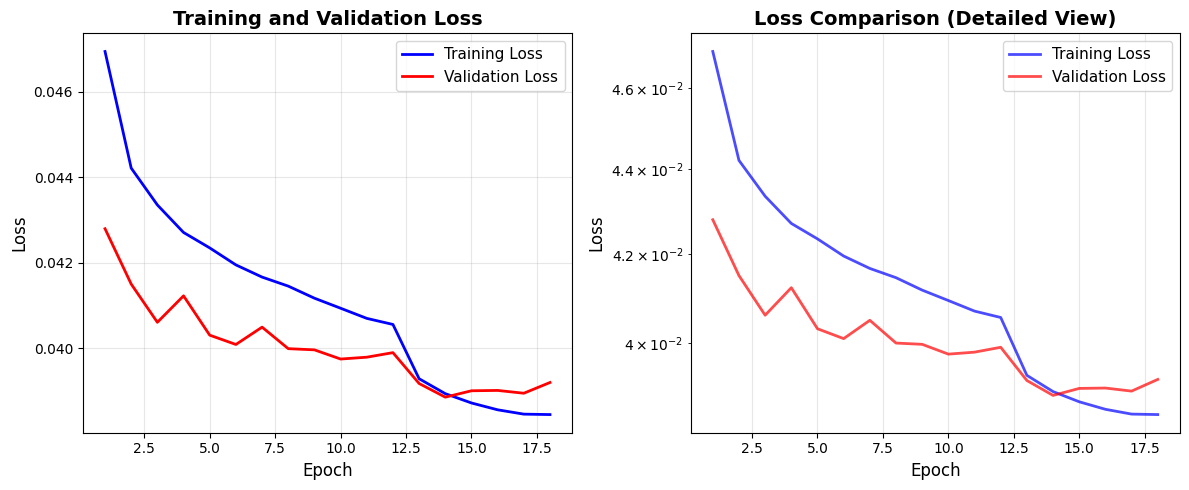


===== TRAINING SUMMARY =====
Final Training Loss: 0.0385
Final Validation Loss: 0.0392
Best Validation AUC: 0.8543
Total Epochs Trained: 18
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/288 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8129 | F1: 0.4013
[Test] Cardiomegaly AUC: 0.9388 | F1: 0.5159
[Test] Consolidation AUC: 0.7772 | F1: 0.2205
[Test] Edema AUC: 0.8992 | F1: 0.3043
[Test] Effusion AUC: 0.8993 | F1: 0.6081
[Test] Emphysema AUC: 0.9681 | F1: 0.5691
[Test] Fibrosis AUC: 0.8441 | F1: 0.1709
[Test] Hernia AUC: 0.9801 | F1: 0.7368
[Test] Infiltration AUC: 0.6970 | F1: 0.3927
[Test] Mass AUC: 0.8983 | F1: 0.4781
[Test] Nodule AUC: 0.7758 | F1: 0.3210
[Test] Pleural_Thickening AUC: 0.8002 | F1: 0.2617
[Test] Pneumonia AUC: 0.6974 | F1: 0.0599
[Test] Pneumothorax AUC: 0.8761 | F1: 0.3524
[Test] Avg AUC: 0.8475, Avg F1: 0.3852


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 0.0421
Avg AUROC : 0.8475
Avg F1    : 0.3852

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8129     0.4013     0.3683    
Cardiomegaly         0.9388     0.5159     0.3742    
Consolidation        0.7772     0.2205     0.3476    
Edema                0.8992     0.3043     0.3603    
Effusion             0.8993     0.6081     0.4402    
Emphysema            0.9681     0.5691     0.4014    
Fibrosis             0.8441     0.1709     0.3631    
Hernia               0.9801     0.7368     0.4652    
Infiltration         0.6970     0.3927     0.3983    
Mass                 0.8983     0.4781     0.4265    
Nodule               0.7758     0.3210     0.3719    
Pleural_Thickening   0.8002     0.2617     0.3160    
Pneumonia            0.6974     0.0599     0.2197    
Pneumothorax         0.8761     0.3524     0.4510    

Average Optimal Thresho

Generating predictions:   0%|          | 0/288 [00:00<?, ?it/s]

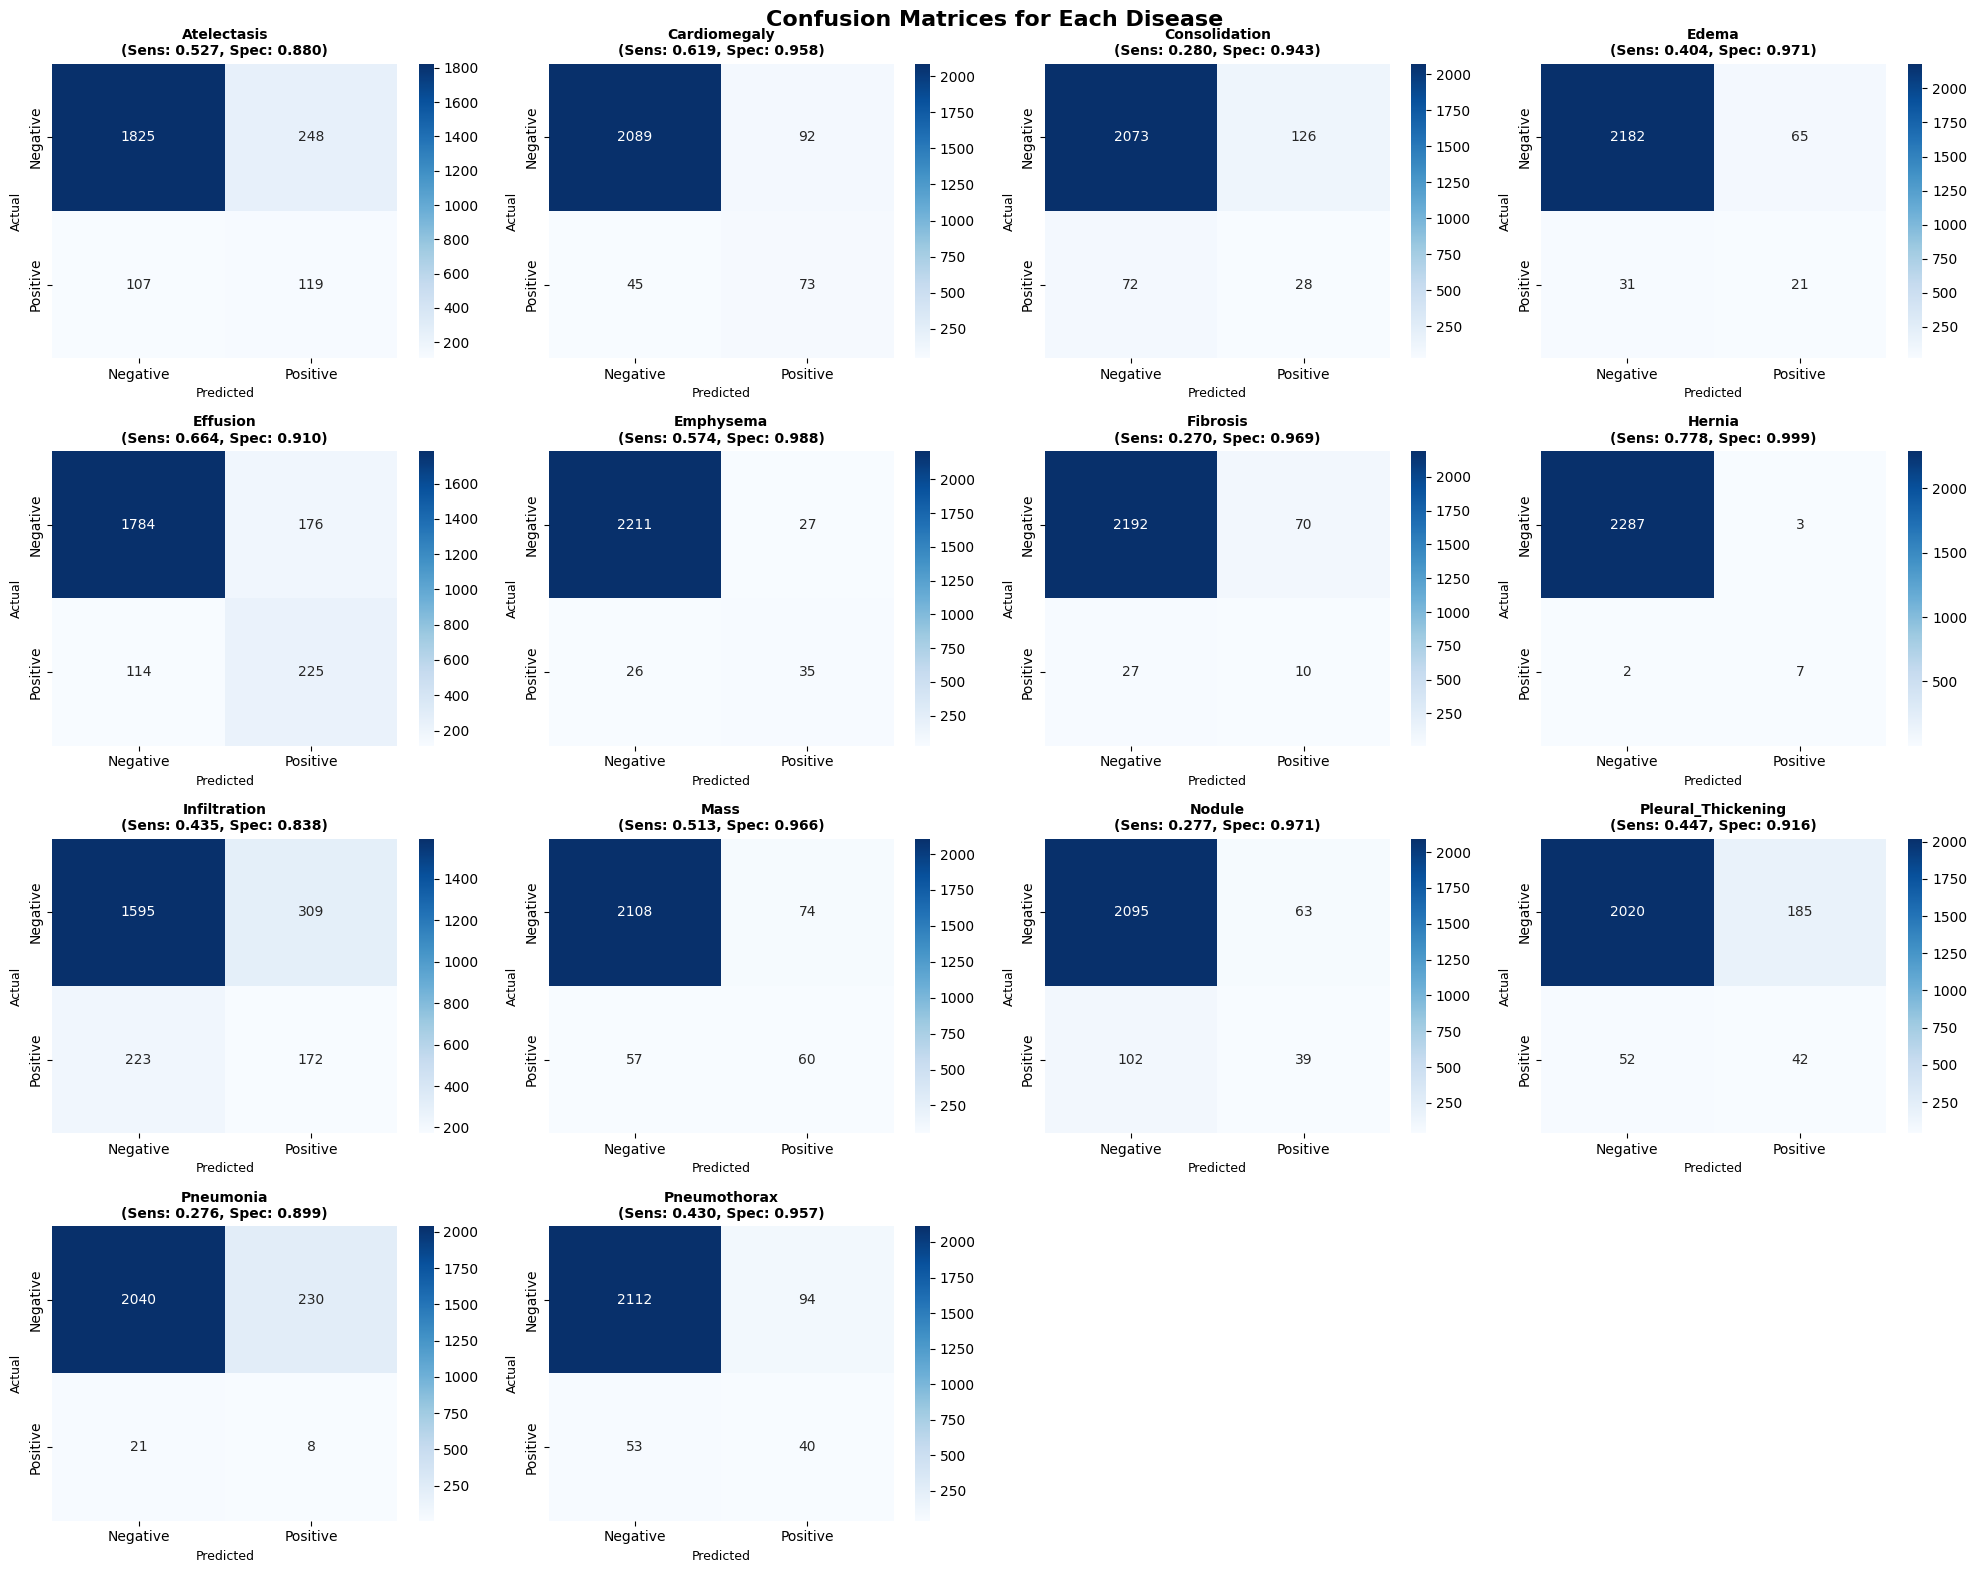

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          119    1825   248    107    0.527    0.880    0.324    0.945   
Cardiomegaly         73     2089   92     45     0.619    0.958    0.442    0.979   
Consolidation        28     2073   126    72     0.280    0.943    0.182    0.966   
Edema                21     2182   65     31     0.404    0.971    0.244    0.986   
Effusion             225    1784   176    114    0.664    0.910    0.561    0.940   
Emphysema            35     2211   27     26     0.574    0.988    0.565    0.988   
Fibrosis             10     2192   70     27     0.270    0.969    0.125    0.988   
Hernia               7      2287   3      2      0.778    0.999    0.700    0.999   
Infiltration         172    1595   309    223    0.435    0.838    0.358    0.877   
Ma